In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
data = pd.read_csv('Numerical Features Continous Outcome.csv')

In [6]:
data = data.drop(data.columns[[0]], axis=1)

In [8]:
X = data[["Annual_Income","Credit_Score","Debt_to_Income","Employment_Length","Age"]].values
y = data["Loan_Approval"].values.reshape(-1,1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
X_test_original = X_test.copy()

In [14]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [16]:
class TabularSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        # return sequence [seq_len=5, 1] and target
        return self.X[i].unsqueeze(-1), self.y[i]

train_ds = TabularSeqDataset(X_train, y_train)
test_ds  = TabularSeqDataset(X_test,  y_test)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=4)



In [18]:
class TabularRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, bidirectional=False):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=bidirectional)
        direction_factor = 2 if bidirectional else 1
        self.head = nn.Linear(hidden_size * direction_factor, 1)

    def forward(self, x):
        # x: [B, seq_len=5, 1]
        out, h_n = self.rnn(x)  
        # h_n: [num_layers * num_directions, B, hidden_size]
        # take last layer’s hidden state:
        last_hidden = h_n[-1]         # [B, hidden_size] (or [B, hidden_size*2] if bidir)
        return self.head(last_hidden) # → [B,1]


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabularRNN().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    total_loss /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item() * xb.size(0)
        val_loss /= len(test_dl.dataset)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}  train MSE={total_loss:.8f}  val MSE={val_loss:.8f}")






Epoch 10  train MSE=0.00003306  val MSE=0.00001191
Epoch 20  train MSE=0.00003069  val MSE=0.00000876


In [22]:
model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test).float().unsqueeze(-1).to(device)
    preds = model(X_test_t).cpu().numpy().flatten()

mse = mean_squared_error(y_test.flatten(), preds)
r2  = r2_score         (y_test.flatten(), preds)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")


Test MSE: 0.0000
Test R² : 0.9998


In [24]:
predictions_df = pd.DataFrame(preds.flatten(), columns=['Loan_Approval_Pred'])

In [29]:
cols = ["Annual_Income","Credit_Score","Debt_to_Income","Employment_Length","Age"]

# 2. Convert the NumPy arrays into DataFrames
X_test_df      = pd.DataFrame(X_test_original, columns=cols)

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age
0,62060.319343,353.290689,0.968948,11.586947,45.0
1,103673.003188,734.158798,0.195106,15.575252,25.0
2,89270.104448,414.860361,0.989355,11.385730,23.0
3,33381.071927,743.248106,0.128248,6.649651,34.0
4,84826.122827,818.050800,0.354751,16.913153,75.0
...,...,...,...,...,...
2995,94322.002703,414.425660,0.881754,13.826463,73.0
2996,123833.627025,465.124911,0.243383,10.934319,59.0
2997,89246.633938,835.664566,0.630416,8.551179,19.0
2998,66442.858834,580.706474,0.405352,15.213339,30.0


In [33]:
merged_df = pd.concat([
    X_test_df.reset_index(drop=True),
    predictions_df.reset_index(drop=True)
], axis=1)

In [37]:
merged_df

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Loan_Approval_Pred
0,62060.319343,353.290689,0.968948,11.586947,45.0,0.421100
1,103673.003188,734.158798,0.195106,15.575252,25.0,0.655092
2,89270.104448,414.860361,0.989355,11.385730,23.0,0.640915
3,33381.071927,743.248106,0.128248,6.649651,34.0,0.260911
4,84826.122827,818.050800,0.354751,16.913153,75.0,0.698159
...,...,...,...,...,...,...
2995,94322.002703,414.425660,0.881754,13.826463,73.0,0.620974
2996,123833.627025,465.124911,0.243383,10.934319,59.0,0.537442
2997,89246.633938,835.664566,0.630416,8.551179,19.0,0.821762
2998,66442.858834,580.706474,0.405352,15.213339,30.0,0.398316


In [35]:
# merged_df.to_csv('Statistical Dataset for Numerical Features and Continous Outcome for RNN.csv', index=False)

In [49]:
import statsmodels.api as sm
from scipy import stats

features = ['Annual_Income', 'Credit_Score', 'Debt_to_Income', 'Employment_Length', 'Age']
DV = 'Loan_Approval_Pred'

scaler = StandardScaler()
X_std = scaler.fit_transform(merged_df[features])
# Convert back to DataFrame for easier manipulation.
X_std_df = pd.DataFrame(X_std, columns=features)

# Define the target
y = merged_df[DV]

# # Add an intercept (constant) to the standardized features.
X_std_const = sm.add_constant(X_std_df)

# # ----------------------------
# # 3. Fit a Multiple Linear Regression Model
# # ----------------------------
model_std = sm.OLS(y, X_std_const)
results_std = model_std.fit()
print(results_std.summary())



scaler_y = StandardScaler()
y_std = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Add an intercept term to the standardized independent variables
X_std_const = sm.add_constant(X_std_df)

# ----------------------------
# 3. Fit the OLS Regression Model on Standardized Data
# ----------------------------
model_std = sm.OLS(y_std, X_std_const)
results_std = model_std.fit()
print("\nOLS Regression Summary on Standardized Data:")
print(results_std.summary())



# Extract Beta Weights (standardized coefficients) excluding the intercept.
beta_weights = results_std.params.drop('const')
print("\nBeta Weights (Standardized Coefficients):")
print(beta_weights)


                            OLS Regression Results                            
Dep. Variable:     Loan_Approval_Pred   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 5.722e+04
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        17:18:25   Log-Likelihood:                 7224.6
No. Observations:                3000   AIC:                        -1.444e+04
Df Residuals:                    2994   BIC:                        -1.440e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5028      0.00

Significant features (p < 0.05), ranked by |β|:

          Feature      Beta  p_value  abs_beta
0   Annual_Income  0.607956      0.0  0.607956
1    Credit_Score  0.593701      0.0  0.593701
2  Debt_to_Income  0.526828      0.0  0.526828


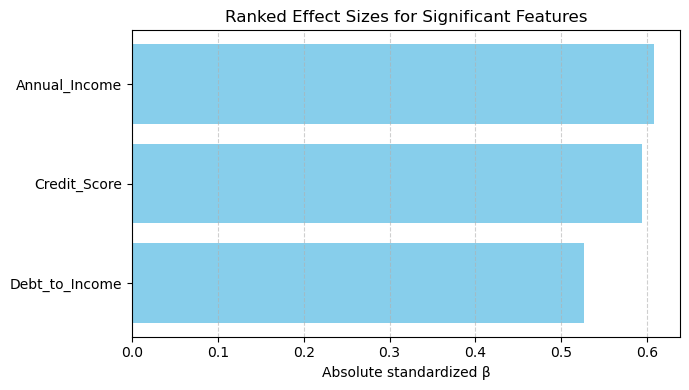

In [59]:
p_vals = results_std.pvalues.drop('const')
betas  = results_std.params   .drop('const')

# 2. Build a DataFrame
significant = pd.DataFrame({
    'Feature':  betas.index,
    'Beta':     betas.values,
    'p_value':  p_vals.values
})

# 3. Filter to p < .05
significant = significant[significant['p_value'] < 0.05].copy()

# 4. Compute absolute β and sort by it descending
significant['abs_beta'] = significant['Beta'].abs()
significant = significant.sort_values('abs_beta', ascending=False).reset_index(drop=True)

# 5. Display
print("Significant features (p < 0.05), ranked by |β|:\n")
print(significant[['Feature','Beta','p_value','abs_beta']])

# 6. Plot
plt.figure(figsize=(7,4))
plt.barh(significant['Feature'], significant['abs_beta'], color='skyblue')
plt.xlabel("Absolute standardized β")
plt.title("Ranked Effect Sizes for Significant Features")
plt.gca().invert_yaxis()  # highest on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [53]:
# beta_weights_sorted = beta_weights.sort_values(ascending=True)

# # Plot the sorted beta weights
# plt.figure(figsize=(8, 6))
# plt.barh(beta_weights_sorted.index, beta_weights_sorted.values, color='skyblue')
# plt.xlabel("Beta Weight (Standardized Coefficient)")
# plt.title("Beta Weights for Each Feature (Sorted in Ascending Order)")
# plt.grid(True, axis='x', linestyle='--', alpha=0.6)
# plt.show()

In [55]:
def compute_feature_recovery_metrics(gt, flagged, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(flagged)
    fp = set(flagged) - set(gt)
    fn = set(gt) - set(flagged)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
    ]
    flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, flagged, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        1.0     1.0  0.0            1


In [24]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt


In [26]:
def predict_regression(x_np):
    """
    x_np: np.array shape (batch, 5), dtype float
    returns: np.array shape (batch,) of raw model outputs
    """
    with torch.no_grad():
        t = torch.from_numpy(x_np).float().unsqueeze(-1).to(device)  # → (batch,5,1)
        out = model(t).cpu().numpy().flatten()                      # raw logits/regression output
    return out


In [28]:
bg_size = 200
bg_idx  = np.random.choice(len(X_train), size=bg_size, replace=False)
background = X_train[bg_idx]  

In [30]:
explainer = shap.KernelExplainer(predict_regression, background)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [32]:
batch_size = 512
all_shap   = []

for start in range(0, X_test.shape[0], batch_size):
    end = min(start + batch_size, X_test.shape[0])
    Xb  = X_test[start:end]  # (batch,5)

    mem = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM = {mem.available/1e9:.2f} GB")

    # nsamples trades speed vs. accuracy
    sv = explainer.shap_values(Xb, nsamples=100)  # shape = (batch,5)
    all_shap.append(sv)


Batch 0-512: free RAM = 4.56 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM = 4.75 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM = 4.73 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM = 4.76 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM = 4.72 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3000: free RAM = 4.77 GB


  0%|          | 0/440 [00:00<?, ?it/s]

In [34]:
all_shap_values = np.vstack(all_shap)

In [40]:
num_feats = ["Annual_Income","Credit_Score","Debt_to_Income","Employment_Length","Age"]

In [42]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=num_feats
).sort_values()


In [44]:
print("Mean |SHAP| per feature (regression):")
print(mean_abs)

Mean |SHAP| per feature (regression):
Age                  0.000629
Employment_Length    0.000718
Debt_to_Income       0.098275
Credit_Score         0.109155
Annual_Income        0.112870
dtype: float64


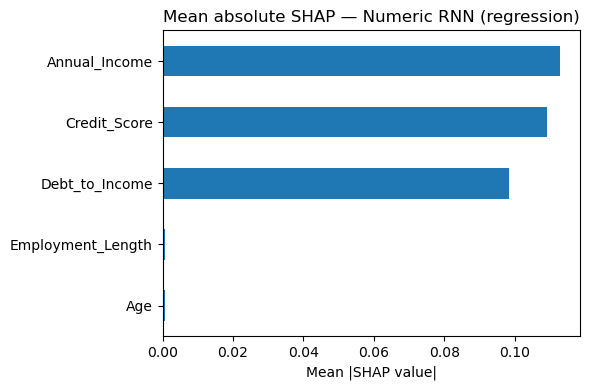

In [48]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP — Numeric RNN (regression)")
plt.tight_layout()
plt.savefig("shap/RNN_numeric_regression_shap.jpg", dpi=300)
plt.show()

In [50]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "Employement_Length",
        "Age"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        0.6     1.0  0.4            1
